# Simulation

[[1]](https://github.com/eitcom/pyEIT)

In [1]:
# coding: utf-8
""" demo on forward 2D """
# Copyright (c) Benyuan Liu. All Rights Reserved.
# Distributed under the (new) BSD License. See LICENSE.txt for more info.
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import numpy as np
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
from pyeit.eit.fem import EITForward, Forward
from pyeit.eit.interp2d import pdegrad, sim2pts
from pyeit.mesh.shape import thorax
from pyeit.mesh.wrapper import PyEITAnomaly_Circle

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from src.util import (plot_mesh, createTrajectory, create2DAnimation, define_mesh_obj)

In [2]:
#helper = []
#helper.append()

#helper2 = np.array()


lookup_list = []

**Berechnung der Trjektorien**

In [3]:
""" 0. build mesh """
n_el = 16
mesh_obj = define_mesh_obj(n_el, use_customize_shape = False)
el_pos = mesh_obj.el_pos 
mesh_obj.print_stats()                     
protocol_obj = protocol.create(n_el, dist_exc=4, step_meas=1, parser_meas="std")    # Erstellt ein Messprotokoll mit spezifischen Parametern


# Berechnet die Vorwärtslösung und EIT-Daten für ein gegebenes Maschennetz.

def calculateData (mesh):
    ex_line = protocol_obj.ex_mat[3].ravel() 
    fwd = Forward(mesh) # Erstellt ein Vorwärtslösungsobjekt für das gegebene Maschennetz. Wird verwendet, um elektrische Felder und Potentiale zu berechnen (im nächsten Schritt)
    f = fwd.solve(ex_line)  # Löst die Vorwärtsproblem für die gewählte Elektrodenanregung. Berechnet die elektrischen Potentiale für das gegebene Maschennetz
    fwd = EITForward(mesh_obj, protocol_obj)
    f= np.real(f) #nur Realteil und eliminiert Imaginärteil
    v = fwd.solve_eit(perm=mesh.perm)   # berechnet Potentialvektor (192 Werte)
    return (f, v)

 #Erstellt die einzelnen Positionen der Anomalie (abhängig von der Anzahl "Nsteps"), Größe der Anomalie über r definierbar, Radius der Kreisbahn mit r_path einstellbar 
def createAnomaly (traj,Nsteps,r,r_path):
    anglePos = np.linspace(0, 2*np.pi, Nsteps)           # P(cos(alpha)=x, sin(alpha)=y)
    perm=100.0
    mesh_new_list = []
    for a in anglePos:
        center = createTrajectory(traj,a,r_path)
        anomaly = PyEITAnomaly_Circle(center, r=r, perm=perm)
        anomaly_mesh = mesh.set_perm(mesh_obj, anomaly=anomaly, background=1.0)
        f, v = calculateData(anomaly_mesh)
        mesh_dict = {"mesh": anomaly_mesh, "x":center[0], "y":center[1], "radius":r, "perm_init":perm, "f":f, "v":v, "anomaly": anomaly}
        mesh_new_list.append(mesh_dict) #erstellt eine Liste aus den Mesh-Dict Daten
        #perm = mesh_new.perm 
    return mesh_new_list




2D mesh status:
1476 nodes, 2821 elements


**Erstellt Plot der Trajektorie**

In [4]:
def checkTraj(mesh_new_list, Nstep):
    
    plt.figure(figsize=(10, 10))
    
    pts = mesh_new_list[0]["mesh"].node
    tri = mesh_new_list[0]["mesh"].element
    
    plt.triplot(pts[:, 0], pts[:, 1], tri, color='gray', alpha=0.5)
    
    x_coords = [mesh_dict["x"] for mesh_dict in mesh_new_list]
    y_coords = [mesh_dict["y"] for mesh_dict in mesh_new_list]
    
    plt.plot(x_coords, y_coords, '-', color='blue', alpha=0.6, 
             label='Trajektorie', linewidth=2)
    
    # Plottet die Anomalie-Positionen
    num_images = Nstep
    step_size = max(Nstep // num_images, 1)  # Schrittgröße, mindestens 1

    # Berechne die Indizes, die für die Bilder verwendet werden
    indices = np.linspace(0, Nstep - 1, num_images, dtype=int)

    for i in indices:
        plt.plot(x_coords[i], y_coords[i], 'ro', markersize=6)
        
        circle = Circle((x_coords[i], y_coords[i]), 
                       radius=mesh_new_list[i]["radius"],
                       fill=False, 
                       color='red',
                       alpha=0.3)
        plt.gca().add_patch(circle)
    
    if hasattr(mesh_new_list[0]["mesh"], 'el_pos'):
        el_pos = mesh_new_list[0]["mesh"].el_pos
        plt.plot(pts[el_pos, 0], pts[el_pos, 1], 'ko', 
                markersize=6, label='Elektroden')
    
    plt.axis('equal')
    
    plt.xlabel('X-Koordinate')
    plt.ylabel('Y-Koordinate')
    plt.title('EIT Mesh mit Anomalie-Trajektorie')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    

In [5]:
def plotMesh(mesh_new_list):

    for i in range(2):
        plot_mesh(mesh_new_list[i]["mesh"])

In [6]:

#mesh_obj.perm_array = gamma  
# Rekonstruktion gamma_hat 
# v, gamma, anomalie (wegen Position und Größe)
# Stage 1 bis 3 ohne LSTM implementieren und trainieren 
#mesh.__dict__

In [7]:
def generateData (traj,Nstep,r_anomaly,r_path, lookup_list,saveData,createGif):

    mesh_new_list = createAnomaly(traj, Nstep, r_anomaly, r_path)
## Speicherung der Daten in einem Data-Folder

    if saveData: 

        base_name = "data"

        counter = 1
        folder_name = base_name
        while os.path.exists(folder_name):
            folder_name = f"{base_name}{counter}"
            counter += 1

        os.makedirs(folder_name) 

        for i in range(len(mesh_new_list)):
            file_path = os.path.join(folder_name, f"sample_{i:06d}.npz")  
            np.savez(file_path, v=mesh_new_list[i]["v"], anomaly=mesh_new_list[i]["anomaly"], gamma = mesh_new_list[i]["mesh"].perm)
    
        lookup = {
            "folder": folder_name,
            "Nstep": Nstep,
            "r_anomaly": r_anomaly,
            "r_path": r_path,
        }
        lookup_list.append(lookup)



    ## Visualisierung der Trajektorie (einzelne Bilder)
    checkTraj(mesh_new_list,Nstep)
    plotMesh(mesh_new_list)
    ## Visualisierung der Trajektorie als gif
    if createGif==True:
        create2DAnimation(traj,mesh_new_list,protocol_obj,mesh_obj)   #Erstellt ein Gif von der simulierten Trajektorie (kann ich für die Verteidigung verwenden)

    return lookup_list

**RUN Simulation**

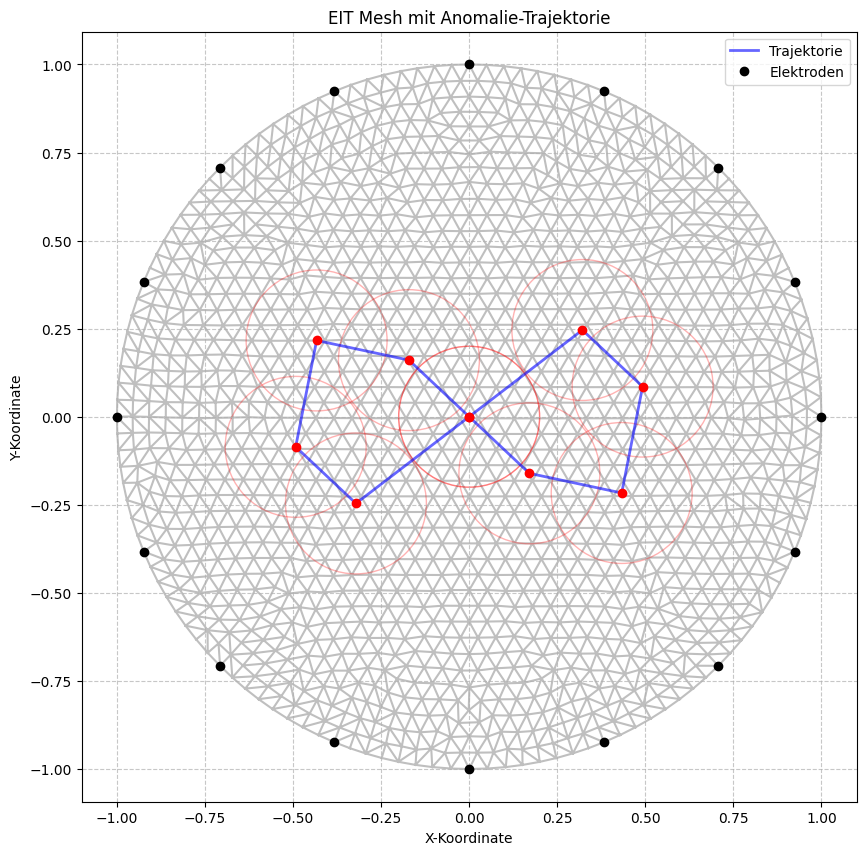

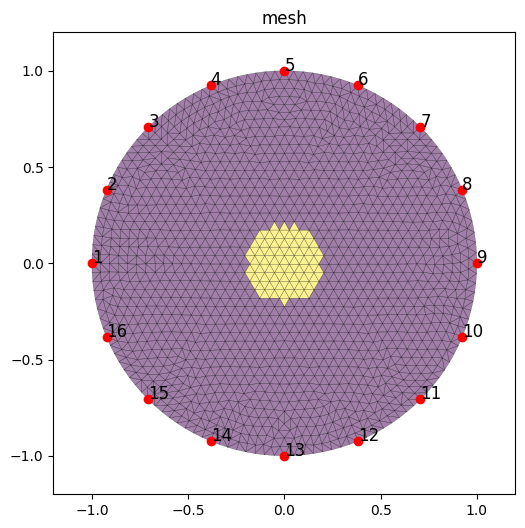

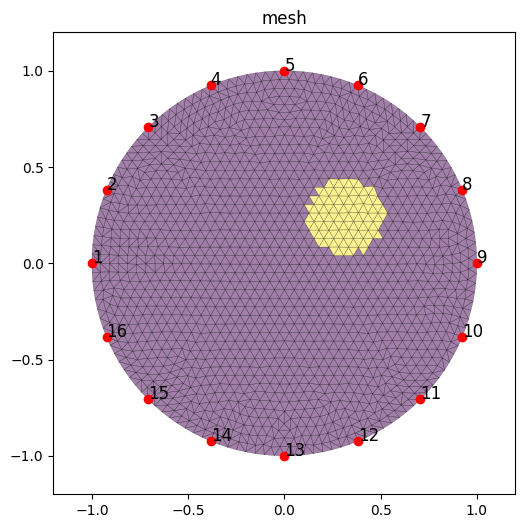

In [8]:
Nstep = 10                    # Anzahl der Steps
r_anomaly = 0.2                # Radius der Anomaly
r_path = 0.5                   # Radius der Kreisbahn 
traj = "eight"
saveData = False
createGif = False

mesh_new_list = generateData(traj,Nstep,r_anomaly,r_path,lookup_list,saveData,createGif)

# print(lookup_list)

#TODO: neue Trajektorien einbauen
#TODO: Elektrodenkonfiguration und Anzahl anpassbar machen
